## Word2vec skip-gram model over http://mattmahoney.net/dc/textdata data

In [4]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.
#To add : scraping implementations

In [6]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes): 
    # Download a file if not present, and make sure it's the right size
    if not os.path.exists(filename): filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string

In [7]:
def read_data(filename):
    # Extract the first file enclosed in a zip file as a list of words
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token :

There may be many unknown words that are not captured by the word2vec vectors simply because these words are not seen often enough in the training data. This may especially be the case with text from e.g. Twitter, where words are often misspelled.

Therefore add an 'unknown word' token to the word2vec dictionary.
Some implementations use a minimum count before adding a word to the vocabulary.

In [8]:
vocabulary_size = 50000

def build_dataset(words):
    # Use collections class to find the vocabulary sized most common words 
    # and store along with their frequencies and with 'UNK' as the first element
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # Build a dictionary with the words in count as keys and index them in the values
    dictionary = dict()
    for word,_ in count:
        dictionary[word] = len(dictionary)    
    # Create an empty list, to store words as they appear, but replace them with their indexes in 'dictionary'
    # Replace words which appear outside 'count' (rare) with index 0 in 'data',
    # corresponding to 'UNK' and update 'unk_count'
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else: 
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count  
    # Create a reverse dictionary to store word indexes as keys and words as values
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data:', data[:10])
# To reduce memory
del words

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data: [5237, 3081, 12, 6, 195, 2, 3136, 46, 59, 156]


Function to generate a batch for training the skip-gram model

In [9]:
data_index = 0

def generate_batch(batch_size, num_skipgrams, skip_window): 
    global data_index # data index has to updated with generation of every batch
    assert batch_size % num_skipgrams == 0 # in one iteration num_skipgrams number of batch entries are added
    assert num_skipgrams <= 2 * skip_window 
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span) # deque structure to always have the span with target word at the center
    # Starting from data_index append span number of elements(word indices) from data to buffer deque
    # For each iteration, an entire span will be in the deque
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skipgrams): #python integer division
        target = skip_window # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skipgrams):
            # Generate random context word index other than the center word itself, 
            # as well as already used words within the span 
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skipgrams + j] = buffer[skip_window] # center word index
            labels[i * num_skipgrams + j, 0] = buffer[target] # context word index
        # Shift the window by 1 to the right and increment data_index
        buffer.append(data[data_index]) 
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data: ', [reverse_dictionary[di] for di in data[:8]])

for num_skipgrams, skip_window in [(2, 1), (4, 2)]:
    batch, labels = generate_batch(batch_size=8, num_skipgrams=num_skipgrams, skip_window=skip_window)
    print('\nwith num_skipgrams = %d and skip_window = %d:' % (num_skipgrams, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])    
    data_index = 0

data:  ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skipgrams = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skipgrams = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'a', 'term', 'originated', 'originated', 'term', 'of', 'as']


Architecture of the neural network

Adagrad is an algorithm for gradient-based optimization that adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters. For this reason, it is well-suited for dealing with sparse data. Dean et al. have found that Adagrad greatly improved the robustness of SGD and used it for training large-scale neural nets at Google, which among other things learned to recognize cats in Youtube videos. Moreover, Pennington et al. used Adagrad to train GloVe word embeddings, as infrequent words require much larger updates than frequent ones, which is the case here.

In [10]:
batch_size = 128
embedding_size = 128 # dimension of the word vectors
skip_window = 1 # how many words to consider left and right
num_skipgrams = 2 # window = 1, therefore span = 3, implies 2 skipgrams(max)
# Pick a random validation set to sample nearest neighbors 
# Limit the validation samples to the words that have a low numeric ID, 
# which by construction are also the most frequent
valid_size = 16 # random set of words to evaluate similarity on
valid_window = 100 # only pick samples at the head of the distribution
# valid_size number of word indices ranging from 0 to valid_window (head of the distribution)
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # number of negetive examples to sample

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    
    # Input data
    tf_train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    tf_train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    tf_valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Variables
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size])) # tensor of shape num_classes
    
    # Model
    # Lookup the word vectors from embeddings given by the indices in train dataset
    embed = tf.nn.embedding_lookup(embeddings, tf_train_dataset)
    # Compute the softmax loss using a sample of the negative labels each time
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases,
                                                    labels=tf_train_labels, inputs=embed,
                                                    num_sampled=num_sampled, num_classes=vocabulary_size))
    # Optimizer
    # The optimizer will optimize the softmax_weights as well as the embeddings
    # This is because the embeddings are defined as a variable quantity and the optimizer's `minimize` method 
    # will by default modify all variable quantities that contribute to the tensor it is passed
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Compute the similarity between validation embeddings and all embeddings using the cosine distance
    # Normalize embeddings and find the dot product between each validation embedding and all the other 
    # word embeddings in the vocabulary
    # The words with greater similarity with the validation embedding will give higher values for the dot product
    norm = tf.sqrt(tf.reduce_mean(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, tf_valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Train the model

In [11]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skipgrams, skip_window)
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        # The average loss is an estimate of the loss over the last 2000 batches
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            print('Average loss at %d: %f' % (step, average_loss))
            average_loss = 0
        # that this is expensive -> ~20% slowdown if computed every 500 steps (originally every 10000 step)
        if step % 10000 == 0:
            sim = similarity.eval() # compute the cosine distances between validation embeddings and all others
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]] # get validation word from reverse dictionary
                top_k = 8 # number of nearest neighbours
                # Get list of dot products corresponding to the ith validation embedding
                # Find the indices that sort list in the decending order and the select the first top_k of them
                # excluding the first one because that would be the dot product of the validation word with itself
                # The indices correspond to the word indices in the vocabulary
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at 0: 8.157152
Nearest to about: eelam, subdominant, surjective, shower, memnon, alyattes, sui, fenian,
Nearest to the: magnesians, frelimo, flock, misr, each, kach, prat, beehives,
Nearest to have: liable, unmanned, exempted, beech, gagarin, blends, etna, view,
Nearest to use: somoza, mapmaking, hydroponic, mpc, foes, grandiose, contraindicated, subdivide,
Nearest to which: alamanni, inklings, aldrich, rollo, aiki, fibs, geckos, drafting,
Nearest to years: garb, present, trembling, pips, mn, carotenoids, reworking, cossack,
Nearest to time: folsom, perfect, larnaca, xilinx, natchez, joachim, solace, postal,
Nearest to often: minamoto, rhondda, functionaries, spill, condensate, research, cretaceous, canute,
Nearest to only: airframes, raft, divisive, inefficient, dollfuss, loudness, sierra, croce,
Nearest to over: wit, summing, mens, sewer, cameraman, adventure, ascended, withholding,
Nearest to would: eicher, forrestal, objection, banting, psc, romanians, enfi

Average loss at 52000: 3.439610
Average loss at 54000: 3.425908
Average loss at 56000: 3.441804
Average loss at 58000: 3.391784
Average loss at 60000: 3.393641
Nearest to about: bothwell, tijuana, corruptions, mayfield, over, miscellaneous, loris, that,
Nearest to the: their, its, a, keynesian, this, some, any, each,
Nearest to have: has, had, were, are, having, be, produce, contain,
Nearest to use: increase, heterodox, bangladeshi, elements, case, hold, agricultural, persecuted,
Nearest to which: that, this, what, however, these, also, husayn, shimazu,
Nearest to years: days, months, times, minutes, year, centuries, hours, hundred,
Nearest to time: way, period, smithsonian, vu, victory, adopters, generation, year,
Nearest to often: sometimes, usually, commonly, typically, generally, now, still, frequently,
Nearest to only: shone, necessarily, until, teletype, cremation, simile, first, precisely,
Nearest to over: into, kilometer, around, quixote, out, elgin, eau, fifty,
Nearest to woul

class sklearn.manifold.TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric=’euclidean’, init=’random’, verbose=0, random_state=None, method=’barnes_hut’, angle=0.5)

t-distributed Stochastic Neighbor Embedding.
t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.
It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

Parameters:

n_components : int, optional (default: 2)
Dimension of the embedded space.

perplexity : float, optional (default: 30)
The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. The choice is not extremely critical since t-SNE is quite insensitive to this parameter.

n_iter : int, optional (default: 1000)
Maximum number of iterations for the optimization. Should be at least 250.

method : string (default: ‘barnes_hut’)
By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.
New in version 0.17: Approximate optimization method via the Barnes-Hut.

tsne.fit_transform: Fit X into an embedded space and return that transformed output.

In [12]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

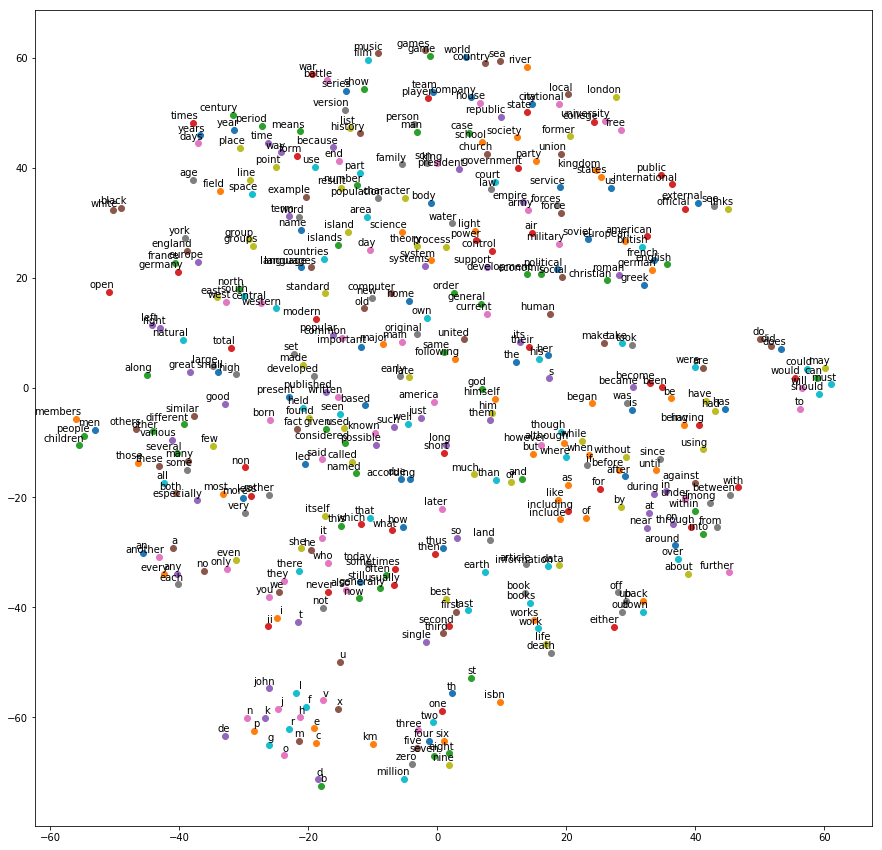

In [13]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)